# Historical Analysis of fMRI QA Data

Individual QA analysis results are saved in a database indexed by the date of the acquisition. These are historical plots of this saved data. Access is required to the QA results datrabase for this.


In [1]:
from __future__ import division, print_function
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from collections import OrderedDict

import psycopg2
import datetime as dt

In [2]:
def fetch_qa_history_pg(field, start_date, end_date):
    '''The given parameter from the postgres database over the given date range. The parameter is specified as one of list of strings
       below which are the column names in the database. The dates specifying the range are strings in ISO YYYY-mm-dd form.
       Returns a tuple of lists. The first element is a list of dates
       as python datetime objects and the second is the recorded values of the parameter.
    '''

    # Database details
    DBNAME    = 'fMRIQAResults'
    DBHOST    = 'canopus.cric.bris.ac.uk'
    DBUSER    = 'apache'
    TABLENAME = 'QACRIC45064'

    # The fields that are tracked - only accept one of these
    FIELDS = [
        "percentFluc", "drift",     "driftfit",
        "mean",        "SNR",       "SFNR",
        "rdc",         "std",
        "minFWHMX",    "meanFWHMX", "maxFWHMX",
        "minFWHMY",    "meanFWHMY", "maxFWHMY",
        "minFWHMZ",    "meanFWHMZ", "maxFWHMZ",
        "dispCMassX",  "driftCMassX",
        "dispCMassY",  "driftCMassY",
        "dispCMassZ",  "driftCMassZ",
        "meanGhost",   "meanBrightGhost",
        "scandate",    "operator",
        "tskip",       "zpos"    ,  "roisize"
    ]
    assert field in FIELDS

    # db wants datetime objects in query
    dates = [dt.datetime.strptime(s, '%Y-%m-%d') for s in (start_date, end_date)]
    assert dates[1] >= dates[0]

    connection = psycopg2.connect(database=DBNAME, host=DBHOST, user=DBUSER)
    
    cursor = connection.cursor()
    query = 'SELECT scandate, %s FROM ' % field + TABLENAME + ' WHERE scandate >= %s AND scandate <= %s'
    cursor.execute(query, dates)
    results = list(cursor.fetchall())
    cursor.close()
    
    connection.close()
    
    return zip(*results)

We extract the data from the QA database file.

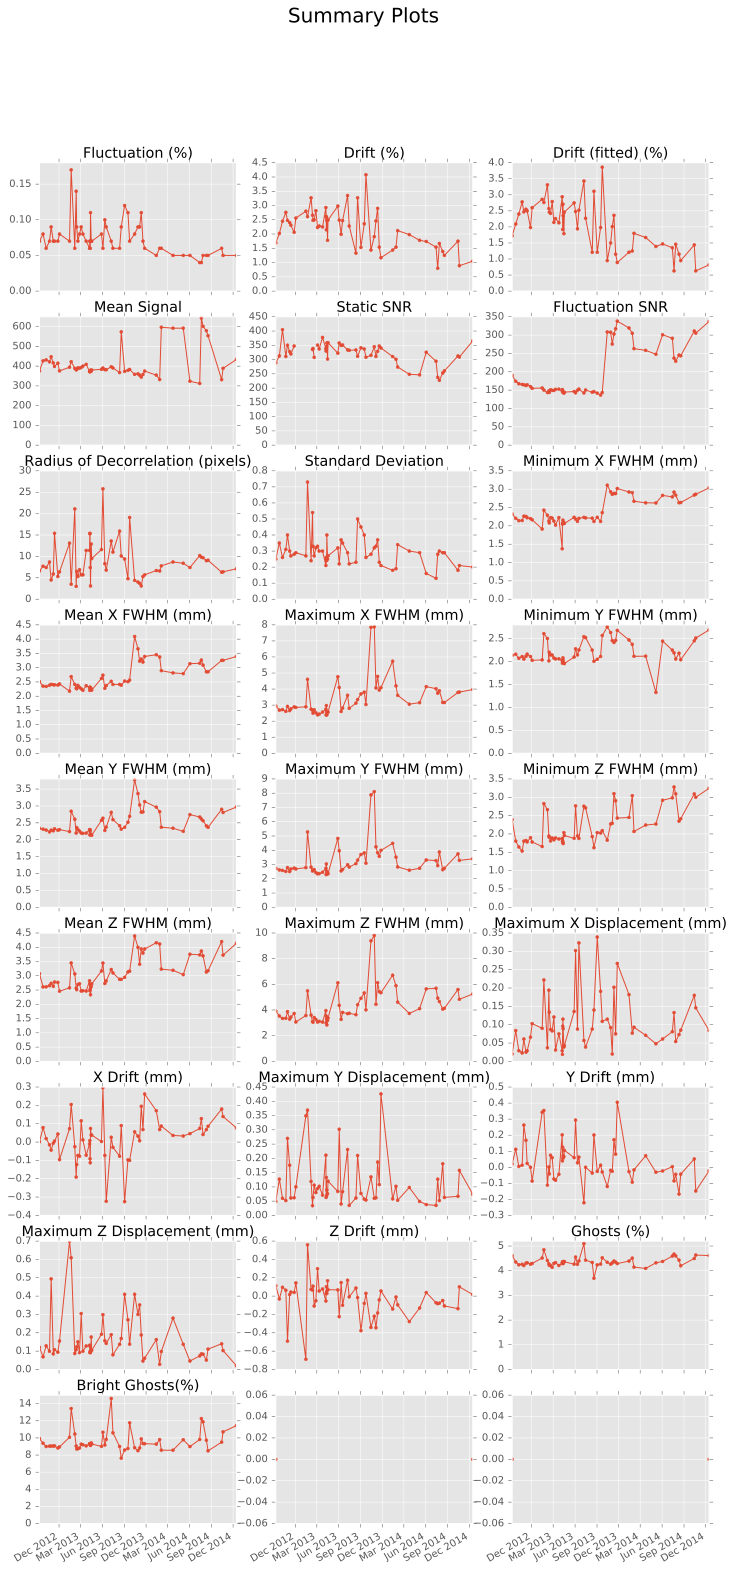

In [3]:
# Small summary plots of all the tracked parameters
start_date, end_date = '2012-01-01', '2014-12-31'

fields_and_labels = OrderedDict([
    ("percentFluc", "Fluctuation (%)"),
    ("drift",       "Drift (%)"),
    ("driftfit",    "Drift (fitted) (%)"),
    ("mean",        "Mean Signal"),
    ("SNR",         "Static SNR"),
    ("SFNR",        "Fluctuation SNR"),
    ("rdc",         "Radius of Decorrelation (pixels)"),
    ("std",         "Standard Deviation"),
    ("minFWHMX",    "Minimum X FWHM (mm)"),
    ("meanFWHMX",   "Mean X FWHM (mm)"),
    ("maxFWHMX",    "Maximum X FWHM (mm)"),
    ("minFWHMY",    "Minimum Y FWHM (mm)"),
    ("meanFWHMY",   "Mean Y FWHM (mm)"),
    ("maxFWHMY",    "Maximum Y FWHM (mm)"),
    ("minFWHMZ",    "Minimum Z FWHM (mm)"),
    ("meanFWHMZ",   "Mean Z FWHM (mm)"),
    ("maxFWHMZ",    "Maximum Z FWHM (mm)"),
    ("dispCMassX",  "Maximum X Displacement (mm)"),
    ("driftCMassX", "X Drift (mm)"),
    ("dispCMassY",  "Maximum Y Displacement (mm)"),
    ("driftCMassY", "Y Drift (mm)"),
    ("dispCMassZ",  "Maximum Z Displacement (mm)"),
    ("driftCMassZ", "Z Drift (mm)"),
    ("meanGhost",   "Ghosts (%)"),
    ("meanBrightGhost", "Bright Ghosts(%)")
])

ncols = 3
nrows = int(np.ceil(len(fields_and_labels)/float(ncols)))

fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=False, figsize=(4*ncols, 3*nrows))
fig.autofmt_xdate()
for i, field in enumerate(fields_and_labels):
    dates, values = fetch_qa_history_pg(field, start_date, end_date)
    ax = axs[i//ncols, i%ncols]
    ax.plot_date(dates, values, '.-')
    if field not in ['driftCMassX', 'driftCMassY', 'driftCMassZ', 'dispCMassX', 'dispCMassY', 'dispCMassZ']:
        ax.set_ylim(bottom=0)
    ax.set_title(fields_and_labels[field])

# Patch up dummy plot to stop subplot errors
dates, values = fetch_qa_history_pg('mean', start_date, end_date)
for i in range(len(fields_and_labels), ncols * nrows):
    ax = axs[i//ncols, i%ncols]
    ax.plot_date([dates[0], dates[-1]], [0]*2, '.')

fig.suptitle('Summary Plots', fontsize=20);

### The Signal to Fluctuation noise and raw SNR ##

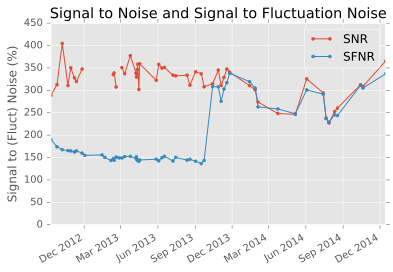

In [4]:
# The Signal to Fluctuation noise and the raw SNR compared
dates, snr = fetch_qa_history_pg('SNR', start_date, end_date)
dates, sfnr = fetch_qa_history_pg('SFNR', start_date, end_date)

fig, ax = plt.subplots(1, 1)

fig.autofmt_xdate()
ax.plot_date(dates, snr, fmt='.-',  label='SNR')
ax.plot_date(dates, sfnr, fmt='.-', label='SFNR')

ax.set_ylim(bottom=0)
ax.grid(True)
ax.set_title('Signal to Noise and Signal to Fluctuation Noise')
ax.set_ylabel('Signal to (Fluct) Noise (%)')
ax.legend();

### The Drift and Fluctuation in Signal ###

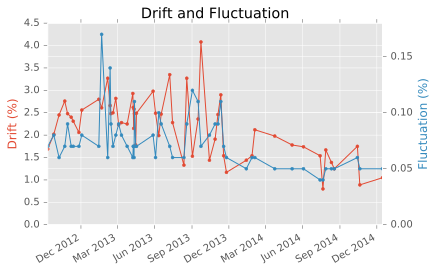

In [5]:
# The longterm drift and fluctuations in Signal
dates, fluct = fetch_qa_history_pg('percentFluc', start_date, end_date)
dates, drift = fetch_qa_history_pg('drift', start_date, end_date)

from mpl_toolkits.axes_grid1 import host_subplot

host = host_subplot(111)
par = host.twinx()

plt.gcf().autofmt_xdate()

p1, = host.plot_date(dates, drift,  fmt='.-', label='Drift')
host.set_ylabel('Drift (%)')

p2, = par.plot_date(dates, fluct,  fmt='.-',  label='Fluct.')
par.set_ylabel('Fluctuation (%)')

host.set_ylim(bottom=0)
par.set_ylim(bottom=0)
host.set_title('Drift and Fluctuation')

host.yaxis.get_label().set_color(p1.get_color())
par.yaxis.get_label().set_color(p2.get_color())
host.xaxis.grid(True)


### Nyquist Ghosting ###

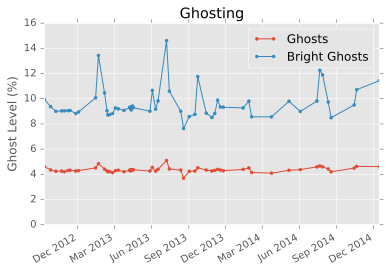

In [6]:
# The average and 'worst' level of Nyquist ghosting

dates, ghosts = fetch_qa_history_pg('meanGhost', start_date, end_date)
dates, brightghosts = fetch_qa_history_pg('meanBrightGhost', start_date, end_date)

fig, ax = plt.subplots(1, 1)

fig.autofmt_xdate()
ax.plot_date(dates, ghosts, fmt='.-',  label='Ghosts')
ax.plot_date(dates, brightghosts, fmt='.-', label='Bright Ghosts')

ax.set_ylim(bottom=0)
ax.set_title('Ghosting')

ax.set_ylabel('Ghost Level (%)')
ax.legend()
ax.grid(True)

### Image Smoothness ###

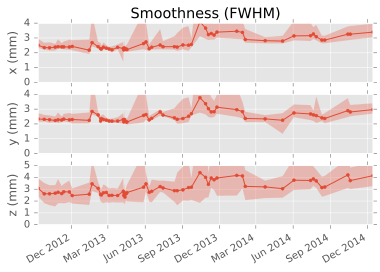

In [7]:
# The image smoothness along each axis, shows the average and the range over the scan time for each date

fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, squeeze=True)
fig.autofmt_xdate()

dates, minfwhmx  = fetch_qa_history_pg("minFWHMX",  start_date, end_date)
dates, meanfwhmx = fetch_qa_history_pg("meanFWHMX", start_date, end_date)
dates, maxfwhmx  = fetch_qa_history_pg("maxFWHMX",  start_date, end_date)

ax = axs[0]
line, = ax.plot_date(dates, meanfwhmx, '.-')
ax.fill_between(dates, minfwhmx, maxfwhmx, facecolor=line.get_color(), alpha=0.3)
ax.set_ylim(bottom=0)
ax.set_ylabel('x (mm)')
ax.set_title('Smoothness (FWHM)')
ax.grid(True)
ax.set_ylim([0, 4])
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

dates, minfwhmy  = fetch_qa_history_pg("minFWHMY",  start_date, end_date)
dates, meanfwhmy = fetch_qa_history_pg("meanFWHMY", start_date, end_date)
dates, maxfwhmy  = fetch_qa_history_pg("maxFWHMY",  start_date, end_date)

ax = axs[1]
line, = ax.plot_date(dates, meanfwhmy, fmt='.-')
ax.fill_between(dates, minfwhmy, maxfwhmy, facecolor=line.get_color(), alpha=0.3)
ax.set_ylim(bottom=0)
ax.set_ylabel('y (mm)')
ax.grid(True)
ax.set_ylim([0, 4])
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

dates, minfwhmz  = fetch_qa_history_pg("minFWHMZ",  start_date, end_date)
dates, meanfwhmz = fetch_qa_history_pg("meanFWHMZ", start_date, end_date)
dates, maxfwhmz  = fetch_qa_history_pg("maxFWHMZ",  start_date, end_date)

ax = axs[2]
line, = ax.plot_date(dates, meanfwhmz, fmt='.-')
ax.fill_between(dates, minfwhmz, maxfwhmz, facecolor=line.get_color(), alpha=0.3)
ax.set_ylim(bottom=0)
ax.set_ylabel('z (mm)')
ax.grid(True)
ax.set_ylim([0, 5])
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

### Image Position Changes ###

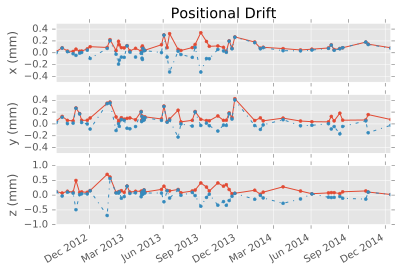

In [8]:
# Positional drift during scan in mm, both the long term drift and the maximum displacement are plotted

fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, squeeze=True)
fig.autofmt_xdate()

dates, dispx  = fetch_qa_history_pg("dispCMassX",  start_date, end_date)
dates, driftx = fetch_qa_history_pg("driftCMassX", start_date, end_date)

ax = axs[0]
ax.plot_date(dates, dispx, '.-')
ax.plot_date(dates, driftx, '.-.')
ax.set_ylim(bottom=0)
ax.set_ylabel('x (mm)')
ax.set_title('Positional Drift')
ax.grid(True)
ax.set_ylim([-0.5, 0.5])

dates, dispy  = fetch_qa_history_pg("dispCMassY",  start_date, end_date)
dates, drifty = fetch_qa_history_pg("driftCMassY", start_date, end_date)

ax = axs[1]
ax.plot_date(dates, dispy, fmt='.-')
ax.plot_date(dates, drifty, fmt='.-.')
ax.set_ylim(bottom=0)
ax.set_ylabel('y (mm)')
ax.grid(True)
ax.set_ylim([-0.5, 0.5])

dates, dispz = fetch_qa_history_pg("dispCMassZ",  start_date, end_date)
dates, driftz = fetch_qa_history_pg("driftCMassZ", start_date, end_date)

ax = axs[2]
ax.plot_date(dates, dispz, fmt='.-')
ax.plot_date(dates, driftz, fmt='.-.')
ax.set_ylim(bottom=0)
ax.set_ylabel('z (mm)')
ax.grid(True)
ax.set_ylim([-1, 1]);

### Weisskoff Summary ##

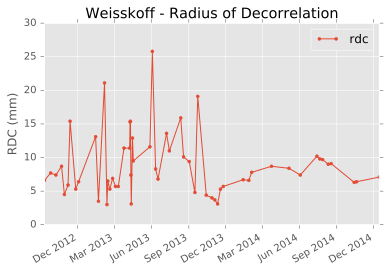

In [9]:
#
# Radius of decorrelation in Weisskoff plot
#

dates, rdc = fetch_qa_history_pg('rdc', start_date, end_date)

fig, ax = plt.subplots(1, 1)

fig.autofmt_xdate()
ax.plot_date(dates, rdc, fmt='.-',  label='rdc')

ax.set_ylim(bottom=0)
ax.grid(True)
ax.set_title('Weisskoff - Radius of Decorrelation')
ax.set_ylabel('RDC (mm)')
ax.legend();